# Symbolic Regression with Likelihood-Based Objectives

View at: https://nbviewer.org/github/IsmamHuda/Symbolic-Regression-with-Likelihood-Based-Objectives/blob/main/Symbolic%20Regression%20with%20Likelihood-Based%20Objectives%20Gamma.ipynb

## About
The purpose of this notebook is to demonstrate how Likelihood-based objectives can be used similar to GLMs and other traditional regression techniques, and to encourage users of GLMs to consider Symbolic Regression in some use cases, as it takes the guess-work out of determining the relationship between the mean and predictors.

## Background
By default, the Symbolic Regression package in Julia uses [Mean Square Error](https://en.wikipedia.org/wiki/Mean_squared_error) as the default objective (as can be seen in [github](https://github.com/MilesCranmer/SymbolicRegression.jl/blob/eafea58565510cca5ed1b8f832ccf27fd233414e/src/Options.jl#L772)) to minimise. Mean Square Error objective is common in regression techniques, including [linear regression via Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares). However, it may not necessarily be suitable or appropriate, espescially if:
- apriori information about the probability distribution of the predicted target ($y$) is known e.g. it is Gamma, or Poisson
- the predicted target has a restricted range e.g. positive counts, probabilities between 0 and 1.

#### Traditional GLMs
Traditional [GLMs](https://en.wikipedia.org/wiki/Generalized_linear_model) use likelihood-based objective functions to fit parameters, and selection of predictors:
- A likelihood-based quantity known as [deviance](https://en.wikipedia.org/wiki/Deviance_(statistics)) is used to fit parameter coefficient estimates $\beta_1, \beta_2$ etc...
- Likelihood-based quantities like [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) and [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) are also used as objectives to perform [forward/ backward selection](https://en.wikipedia.org/wiki/Stepwise_regression) to determine which predictors ($x_1, x_2$ etc...) are added/removed to the linear term (η). They combine the log-likelihood with a penalty term to penalise overfitting & model complexity.  

Using likelihood-based objectives in this way results in a fitted model that:
- uses all available apriori information, and hence a more accurate model
- has Maximum Likelihood Estimate parameter estimates.

#### Using Custom Likelihood-Based Objectives With Symbolic Regression
The Symbolic Regression package in Julia allows custom objective functions, and these can be set by the user to be likelihood-based, namely the deviance as used in GLMs. This allows Symbolic Regression to achieve the same benefits of likelihood-based objectives. However, unlike with GLMs, with symbolic regression, we are no longer constrained by the requirement that our predictors be linear, as Symbolic Regression is able to search the space of all feasible functions involving our predictor variables. This allows symbolic regression to naturally discover predictors that have:
- non-linear effects
- interaction effects
- a desired balance of accuracy (goodness of fit) and simplicity by penalising equation complexity 

Users of GLMs by contrast will need to resort to additional steps to achieve the same goals, and these steps often require lucky guesses about the nature of the non-linearity or interaction to trial and error.

A brilliant demonstration of the Symbolic Regression package searching for an equation is available on [Github](https://github.com/MilesCranmer/SymbolicRegression.jl):  
<video src="https://github.com/MilesCranmer/SymbolicRegression.jl/assets/7593028/f5b68f1f-9830-497f-a197-6ae332c94ee0" width="640" height="360" controls></video>  
Credit Miles Cranmer.

# Setup

In [1]:
# Check threads being used. Up to 10 for my M4 MacBook Air.

using Base.Threads
Threads.nthreads()

8

In [2]:
# Set random seed variables for reproducibility
my_seed = 2025;

In [3]:
# load packages
using Pkg, Statistics, Random, Distributions, DataFrames, SymbolicUtils, StatsBase, Plots, PlotlyJS;

using SymbolicRegression: SRRegressor, node_to_symbolic, eval_tree_array
using LoopVectorization  # Helps speed up but experiemental 
using MLJ: machine, fit!, predict, report


# Likelihood-based objective functions from GLM and BetaRegression packages
using GLM: devresid, linkinv, LogitLink, LogLink, IdentityLink, InverseLink, ProbitLink
using BetaRegression: devresid



WebIO._IJuliaInit()

In [4]:
# PlotlyJS backend for Plots, to render interactive 3D
plotlyjs();

# Generate Mock Data
In this step we generate Mock Data, with a predetermined distribution. We will then see if Symbolic Regression is able to recover the equation just using data alone.

$Y|x \sim Gamma(\alpha, \theta) $ where $ E(Y|x) = x_1x_2^{3.2} + x_1 $

With $50 \le x_1 \le 150$ and $ 0 \le x_2 \le 30 $  
Scale parameter (θ) of the Gamma distribution is set so that standard deviation = 0.5$E(Y|x)$. A high standard deviation is used in the hopes to assess model performance under a high-noise environment.  
$\text{E}(Y|x) = \alpha\theta \text{ and } \text{Var}(Y|x) = \alpha\theta^2 = (0.5\text{E}(Y|x))^2$  
$∴ α = 1/0.25 = 4 \text{ and } θ = 0.25\text{E}(Y|x)=0.25(x_1x_2^{3.2} + x_1)$

In [5]:
# Define logistic function
logistic(x::T) where {T <: Real} = inv(one(T) + exp(-x));

In [6]:
obs=5000

# Generate random X values
Random.seed!(my_seed)
mockdata = DataFrame(
    x1 = rand(Uniform(50,150), obs),
    x2 = rand(Uniform(1,30), obs)
)

# What is standard deviation as a percent of mean
# Higher value = more noise
std_over_mean = 0.5

# Generate observations from Gamma distribution, with mean a function of the X values, like a GLM
transform!(mockdata, [:x1, :x2] => ((x1, x2) -> x1.*(x2.^3.2) + x1) => :mean)
transform!(mockdata, :mean => ((mean) -> rand.(Gamma.(inv(std_over_mean^2), std_over_mean^2 .* mean))) => :Y_obs)

first(mockdata, 10)

Row,x1,x2,mean,Y_obs
,Float64,Float64,Float64,Float64
1,107.663,1.1221,263.322,134.282
2,133.26,20.6327,2.14441e6,1.50425e6
3,99.2985,13.9199,4.536e5,758186.0
4,139.318,14.8186,777440.0,1.09076e6
5,137.125,20.0026,1.99811e6,3.01462e6
6,136.781,27.8127,5.72286e6,2.61695e6
7,127.501,20.4116,1.98222e6,1.34173e6
8,110.928,25.8438,3.66939e6,3.75285e6
9,57.084,8.71946,58412.4,92410.2


In [7]:
# Subset
X = mockdata[:, [:x1, :x2]];
y = mockdata[:, :Y_obs];

# Visualise Data

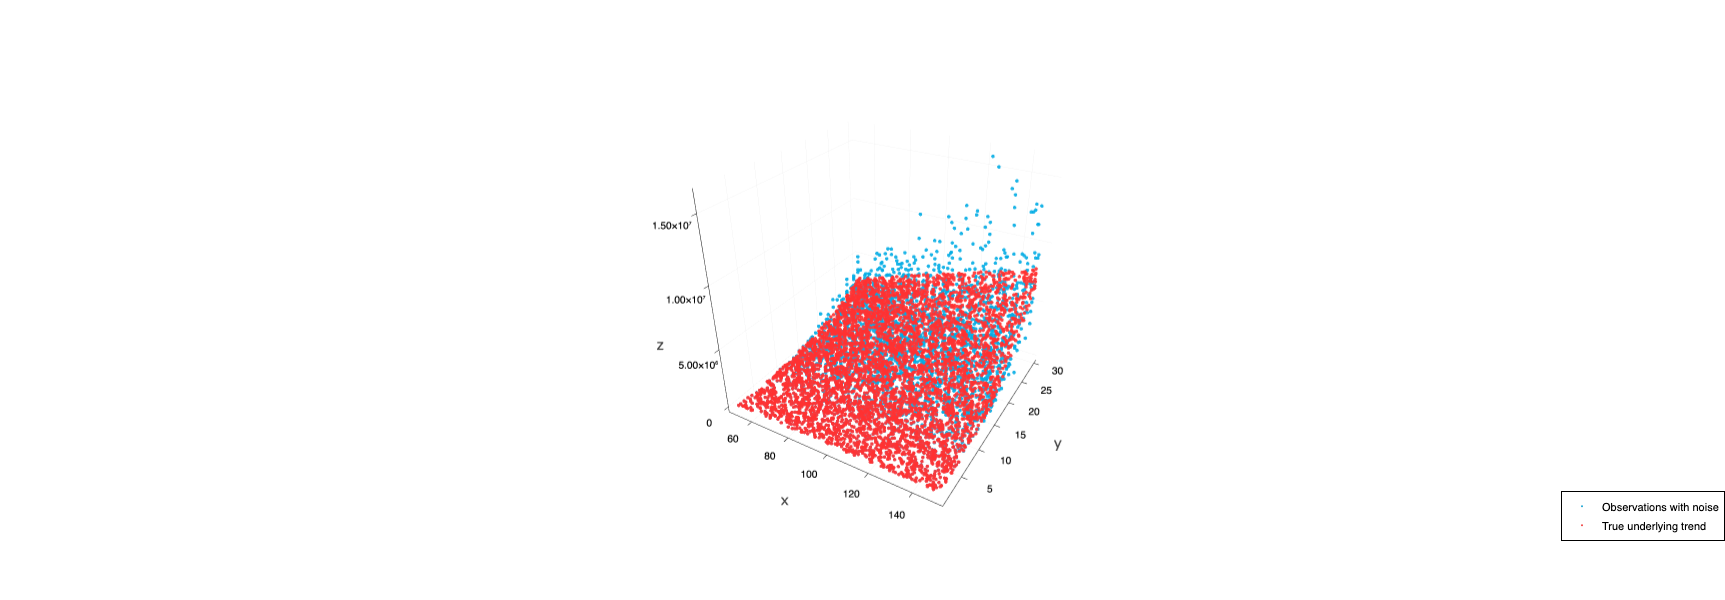

In [8]:
Plots.scatter(
    mockdata.x1,
    mockdata.x2,
    mockdata.Y_obs,
    label = "Observations with noise",
    markerstrokewidth = 0,
    markersize = 1,          # smaller dots
    alpha = 0.9,              # more transparency
    color = :deepskyblue3,      # clearer blue than default
    xlabel = "x1",
    ylabel = "x2",
    zlabel = "Obs / Mean",
    legend = :bottomright,
    size = (1000,600)
)

Plots.scatter!(
    mockdata.x1,
    mockdata.x2,
    mockdata.mean,
    label = "True underlying trend",
    markerstrokewidth = 0,
    markersize = 1,          # slightly larger for emphasis
    alpha = 0.9,               # solid but not harsh
    color = :firebrick2        # strong red, not neon
)

# plot!(
#     gridalpha = 0.12,
#     camera = (30, 25)
# )

# Design Custom Loss Function

### Deviance Explanation

The formula for deviance is:  
$D = -2[\ell(\hat{\boldsymbol{\beta}}) - \ell_s]$

Most implementations of GLMs use what's known as the deviance residual squared, which is the contribution an individual observation makes to the overall deviance. These are summed over to get the total deviance. 
$\sum_{i} d_i^2 = D$

Deviance residual squared formulas have been directly imported from the GLM package for Julia with:
```julia
using GLM: devresid
```

The current formulae used for Gamma at time of writing is shown below (available at: https://github.com/JuliaStats/GLM.jl/blob/23a4e2040e1279652e55fcd2f5e74018de944923/src/glmtools.jl#L419)  

```julia
devresid(::Gamma, y, μ::Real) = -2 * (log(y / μ) - (y - μ) / μ)
```

In [9]:
# Define custom objective function, using devresid
"""
    custom_likelihood_based_obj(D)

Returns a custom loss function (closure) that calculates the total deviance
for a specific GLM family D.

Allowable link function options from GLM package:
LogitLink()
LogLink()
IdentityLink()
InverseLink()
ProbitLink()

"""
function custom_likelihood_based_obj(family, link_function=IdentityLink())
    
    # This is the inner function that SRRegressor calls:
    function custom_likelihood_based_obj_w_dist(tree, dataset, options)

        eta, flag = eval_tree_array(tree, dataset.X, options)
        !flag && return Inf
        
        # Use GLM's own inverse link logic
        # linkinv(link, eta) transforms eta -> mu
        mu_pred = linkinv.(link_function, eta)
        
        # 2. CRITICAL LOGIC FIX: Deviance = SUM(devresid^2)
        # devresid order: devresid(Family, y, μ)
        # Use abs2() to square the residual and sum() to get total Deviance
        # This is the standard GLM objective.
        total_deviance = sum(devresid.(family, dataset.y, mu_pred))
        
        # Ensure the loss is a non-negative scalar
        return total_deviance
    end
    
    # Return the inner function (the closure)
    return custom_likelihood_based_obj_w_dist
end

custom_likelihood_based_obj

# Fit Model With Custom Loss Function

In [17]:
model = SRRegressor(
    binary_operators=[+,*,-,/,^],
    unary_operators=[abs, inv, log, exp, sin, cos, tan],
    niterations=50,
    should_simplify = true,
    should_optimize_constants = true,
    print_precision=2,
    seed=my_seed,
    turbo = true,  
    save_to_file = false,
    loss_function=custom_likelihood_based_obj(Gamma(), LogLink()),
    progress = false);

In [18]:
# Train model
mach = machine(model, X, y)
fit!(mach)

[ Info: Training machine(SRRegressor(defaults = nothing, …), …).
[ Info: Started!



Expressions evaluated per second: 2.130e+04
Progress: 97 / 1550 total iterations (6.258%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.569e+04  0.000e+00  y = 14
5           8.290e+03  1.596e-01  y = (x2 / 8.1) + 12
6           2.552e+03  1.178e+00  y = tan((x2 ^ 0.02) - -3.6)
15          2.380e+03  7.762e-03  y = ((((x1 * x2) / ((x1 * 0.66) ^ 0.42)) ^ 0.39) - -2.5) +...
                                       1.7
17          NaN       -0.000e+00  y = (0.59 * (x1 * abs(0.59 * (x1 * abs(abs(-0.25 - inv(-1....
                                      5))))))) / 1.2
19          1.909e+03  1.456e+01  y = ((x1 * (x2 / (x1 * 0.085))) ^ (0.44 - ((x2 / (x1 * x2)...
                                      ) * 1.9))) + 4.3
20          NaN       -0.000e+00  y = abs(abs(((x1 * (0.59 * ((x1 * 0

[ Info: Final population:


trained Machine; caches model-specific representations of data
  model: SRRegressor(defaults = nothing, …)
  args: 
    1:	Source @164 ⏎ ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}
    2:	Source @773 ⏎ AbstractVector{ScientificTypesBase.Continuous}


In [14]:
# Organise results into dictionary
report_mach = report(mach);
report_dict = Dict(pairs(report_mach));
delete!(report_dict, :best_idx);
# delete!(report_dict, :equations);

# Organise into dataframe for easy inspection
report_df = DataFrame(report_dict)
report_df[!, :score_rank] = competerank(-report_df.scores)
report_df

# Best result (tradeoff between simplicity and fit) has score_rank=1

Row,complexities,equation_strings,equations,losses,scores,score_rank
,Int64,String,Expressi…,Float64,Float64,Int64
1,1,14.0685582054254,14.0685582054254,15694.8,0.0,12
2,4,tan(exp(sin(x2))),tan(exp(sin(x2))),NaN,-0.0,12
3,5,(x2 ^ 0.6421564219166358) + 7.217139819356626,(x2 ^ 0.6421564219166358) + 7.217139819356626,2932.53,28.419,1
4,6,(log(x2) + 1.528673088458213) * 3.1302552661914245,(log(x2) + 1.528673088458213) * 3.1302552661914245,1697.16,0.54691,3
5,7,log(x1) + log(x2 ^ 3.1960216509843486),log(x1) + log(x2 ^ 3.1960216509843486),1258.04,0.299399,4
6,9,log(x1) + log(0.9596665312564571 + (x2 ^ 3.1950212324552036)),log(x1) + log(0.9596665312564571 + (x2 ^ 3.1950212324552036)),1238.16,0.00796464,5
7,11,log(x1) + log((x2 ^ 3.194988017770355) + cos(cos(x2))),log(x1) + log((x2 ^ 3.194988017770355) + cos(cos(x2))),1237.97,7.88695e-5,11
8,12,log(x1) + log(((x2 ^ 3.182348303677375) * 1.0369167454586234) + sin(x2)),log(x1) + log(((x2 ^ 3.182348303677375) * 1.0369167454586234) + sin(x2)),1237.83,0.00010955,9
9,13,log(x1) + log((1.0369167454586234 * (x2 ^ 3.182348303677375)) + abs(sin(x2))),log(x1) + log((1.0369167454586234 * (x2 ^ 3.182348303677375)) + abs(sin(x2))),1237.65,0.000144069,8


In [15]:
# Identify best expression

# best_expression = report_mach[2][report_mach[1]]                        # Best expression according to report_mach. Sometimes produces unexpected results.
best_expression = report_mach[2][findfirst(report_df.score_rank .== 1)]   # Best expression according to score_rank
best_expression_eqn = node_to_symbolic(best_expression)
best_expression_eqn_simp = simplify(best_expression_eqn)
best_expression_eqn_simp

7.217139819356626 + (x2 ^ 0.6421564219166358)

#### Comment
Almost identified true relationship of $ E(Y|x) = x_1x_2^{3.2} + x_1 $. Just missing the $+1$ inside brackets.